<a href="https://colab.research.google.com/github/momova97/ALY6110/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 6 Final Project

By Mohammad Hossein Movahedi

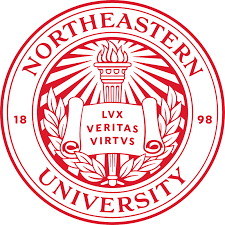

Today's date: 2023-12-10

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files

# Upload your Kaggle API key
files.upload()

# Move the key to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# dataset download
!kaggle datasets download -d asaniczka/amazon-canada-products-2023-2-1m-products



Saving kaggle.json to kaggle.json
 92% 132M/144M [00:01<00:00, 81.9MB/s]
100% 144M/144M [00:01<00:00, 83.0MB/s]


In [ ]:
# Unzip the dataset
!unzip -q amazon-canada-products-2023-2-1m-products.zip -d ./data

In [ ]:
!pip install pyspark

from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("AmazonCanadaAnalysis").getOrCreate()

# Load the dataset
df = spark.read.csv('/content/data/amz_ca_total_products_data_processed.csv', header=True, inferSchema=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=e9b9ea5547ac61d7ff5c36a3b67866cd8ec8f856a52cfaafc777424ab801675d
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql.functions import isnan, when, count, col
# Display the DataFrame schema
df.printSchema()

# Show summary statistics
df.describe().show()

# Check for missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Drop duplicates and handle missing values as needed
df_cleaned = df.dropDuplicates().na.fill({"listPrice": 0}) # filling missing listPrice with 0

root
 |-- asin: string (nullable = true)
 |-- title: string (nullable = true)
 |-- imgUrl: string (nullable = true)
 |-- productURL: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- listPrice: string (nullable = true)
 |-- categoryName: string (nullable = true)
 |-- isBestSeller: string (nullable = true)
 |-- boughtInLastMonth: string (nullable = true)

+-------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+-----------------+-------------------+-----------------+--------------------+
|summary|                asin|               title|              imgUrl|           productURL|               stars|             reviews|               price|        listPrice|       categoryName|     isBestSeller|   boughtInLastMonth|
+-------+--------------------+--------------------+--------------------+--------

In [ ]:
df_cleaned = df.na.drop(subset=["imgUrl", "stars", "reviews", "boughtInLastMonth"])
# Check for missing values
df_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+-----+------+----------+-----+-------+-----+---------+------------+------------+-----------------+
|asin|title|imgUrl|productURL|stars|reviews|price|listPrice|categoryName|isBestSeller|boughtInLastMonth|
+----+-----+------+----------+-----+-------+-----+---------+------------+------------+-----------------+
|   0|    0|     0|         0|    0|      0|    0|        0|           0|           0|                0|
+----+-----+------+----------+-----+-------+-----+---------+------------+------------+-----------------+



In [ ]:
# Remove rows where 'price' is null or NaN
df_cleaned = df_cleaned.filter(~(isnan(col("price")) | col("price").isNull()))

In [ ]:
from pyspark.sql.functions import col

# Convert isBestSeller to numerical value
df_cleaned = df_cleaned.withColumn("isBestSeller", col("isBestSeller").cast("integer"))
# Ensure that 'stars' and 'price' are of a numerical type
df_cleaned = df_cleaned.withColumn("stars", col("stars").cast("float"))
df_cleaned = df_cleaned.withColumn("price", col("price").cast("float"))
df_cleaned = df_cleaned.withColumn("reviews", col("reviews").cast("float"))

# Calculate correlations
print("Correlation between stars and price:", df_cleaned.stat.corr("stars", "price"))
print("Correlation between reviews and price:", df_cleaned.stat.corr("reviews", "price"))
print("Correlation between stars and isBestSeller:", df_cleaned.stat.corr("stars", "isBestSeller"))
print("Correlation between reviews and isBestSeller:", df_cleaned.stat.corr("reviews", "isBestSeller"))

Correlation between stars and price: 0.9923098616539626
Correlation between reviews and price: 0.9940433778168181
Correlation between stars and isBestSeller: 0.00014394855188372708
Correlation between reviews and isBestSeller: -1.9018417641302189e-06


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

df_cleaned = df_cleaned.filter(~(isnan(col("price")) | col("price").isNull()))

# Assemble features with handling invalid (null) values by skipping them
assembler = VectorAssembler(inputCols=["stars", "reviews"], outputCol="features", handleInvalid="skip")
df_features = assembler.transform(df_cleaned)
# Split the data into training and test sets
train_data, test_data = df_features.randomSplit([0.7, 0.3])
train_data = train_data.filter(~isnan(col('price')) & ~col('price').isNull())
test_data = test_data.filter(~isnan(col('price')) & ~col('price').isNull())
# Train the model
lr = LinearRegression(featuresCol='features', labelCol='price')
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

Root Mean Squared Error (RMSE) on test data = 49279.943600777035


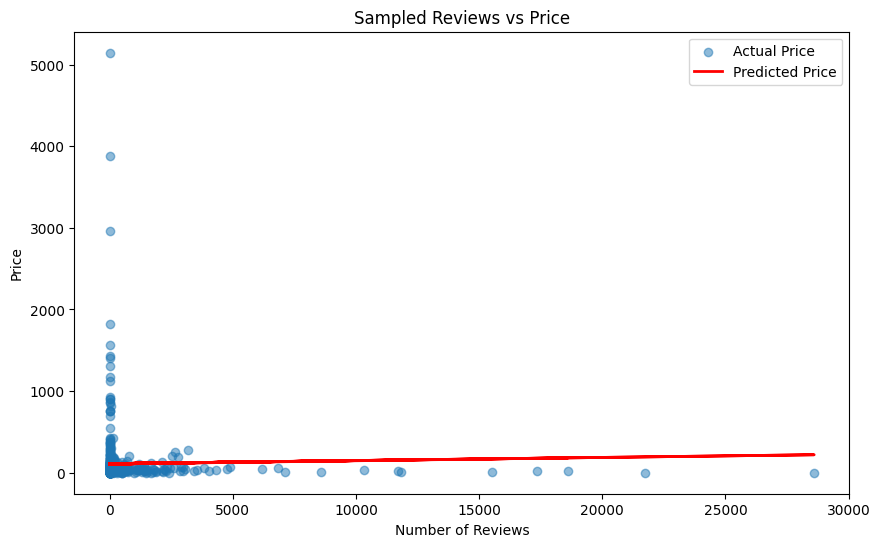

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample 0.1% of the data randomly without replacement
sampled_predictions = predictions.sample(False, 0.001)

# Convert to Pandas DataFrame
result_pdf = sampled_predictions.select("reviews", "price", "prediction").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(result_pdf['reviews'], result_pdf['price'], alpha=0.5, label='Actual Price')
plt.plot(result_pdf['reviews'], result_pdf['prediction'], color='red', linewidth=2, label='Predicted Price')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.title('Sampled Reviews vs Price')
plt.legend()
plt.show()

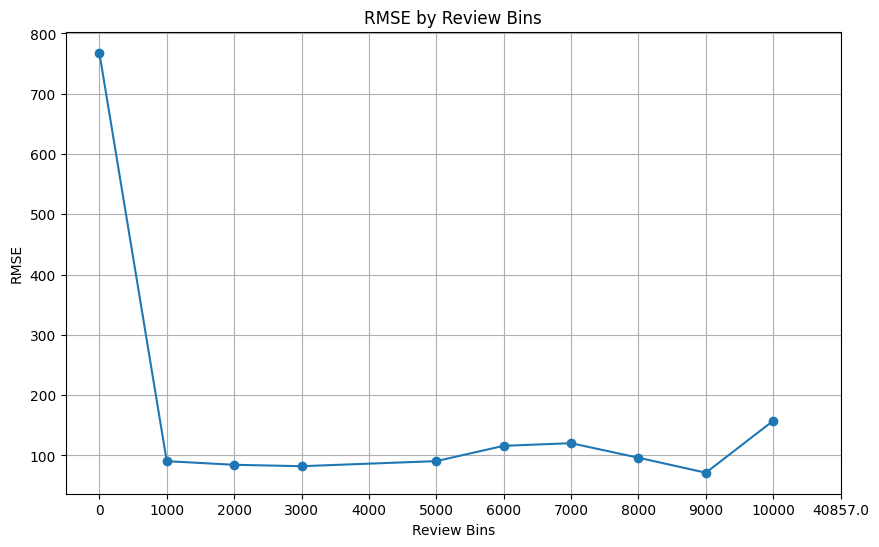

In [ ]:
from pyspark.sql.functions import col, sqrt, avg
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import Bucketizer

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# Sample 0.1% of the data randomly without replacement
sampled_predictions = predictions.sample(False, 0.001)

# Find the maximum value in the 'reviews' column
max_reviews = sampled_predictions.agg({"reviews": "max"}).collect()[0][0]

# Define the bins, making sure the last bin covers the maximum value
bins = [0, 1000, 2000, 3000, 4000, 5000, 6000,7000,8000,9000,10000, max_reviews]

# Create the bucketizer
bucketizer = Bucketizer(splits=bins, inputCol="reviews", outputCol="review_bins")

# Apply the bucketizer to create the bins
predictions_binned = bucketizer.transform(sampled_predictions)


# Group by the review_bins and calculate RMSE for each bin
rmse_by_bin = (
    predictions_binned
    .groupBy("review_bins")
    .agg(
        sqrt(avg((col("price") - col("prediction"))**2)).alias("rmse")
    )
    .orderBy("review_bins")
)

# Collect the data and plot
rmse_by_bin_data = rmse_by_bin.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(rmse_by_bin_data['review_bins'], rmse_by_bin_data['rmse'], marker='o')
plt.xlabel('Review Bins')
plt.ylabel('RMSE')
plt.title('RMSE by Review Bins')
plt.xticks(ticks=range(len(bins)), labels=bins)
plt.grid(True)
plt.show()

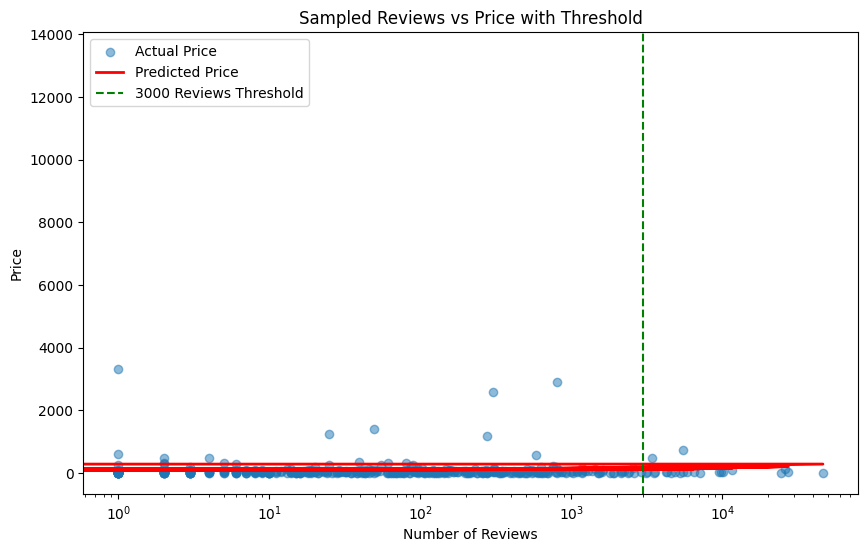

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample 0.1% of the data randomly without replacement
sampled_predictions = predictions.sample(False, 0.001)

# Convert to Pandas DataFrame
result_pdf = sampled_predictions.select("reviews", "price", "prediction").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(result_pdf['reviews'], result_pdf['price'], alpha=0.5, label='Actual Price')
plt.plot(result_pdf['reviews'], result_pdf['prediction'], color='red', linewidth=2, label='Predicted Price')
plt.axvline(x=3000, color='green', linestyle='--', label='3000 Reviews Threshold')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.title('Sampled Reviews vs Price with Threshold')
plt.legend()
plt.xscale('log')  # Optional: Use logarithmic scale if the reviews vary by orders of magnitude
plt.show()

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Split the data
above_3000_df = predictions.filter(col("reviews") > 3000).drop('prediction')
below_3000_df = predictions.filter(col("reviews") <= 3000).drop('prediction')

# Train a new model on data with more than 3000 reviews
lr_above_3000 = LinearRegression(featuresCol='features', labelCol='price')
lr_model_above_3000 = lr_above_3000.fit(above_3000_df)

# Train a new model on data with less than or equal to 3000 reviews
lr_below_3000 = LinearRegression(featuresCol='features', labelCol='price')
lr_model_below_3000 = lr_below_3000.fit(below_3000_df)

# Evaluate the models
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# Make predictions and evaluate the new models
above_3000_predictions = lr_model_above_3000.transform(above_3000_df)
above_3000_rmse = evaluator.evaluate(above_3000_predictions)

below_3000_predictions = lr_model_below_3000.transform(below_3000_df)
below_3000_rmse = evaluator.evaluate(below_3000_predictions)

# Compare the models
print(f"Above 3000 reviews model RMSE: {above_3000_rmse}")
print(f"Below 3000 reviews model RMSE: {below_3000_rmse}")

Above 3000 reviews model RMSE: 1561.7408729148315
Below 3000 reviews model RMSE: 509.1003072470135


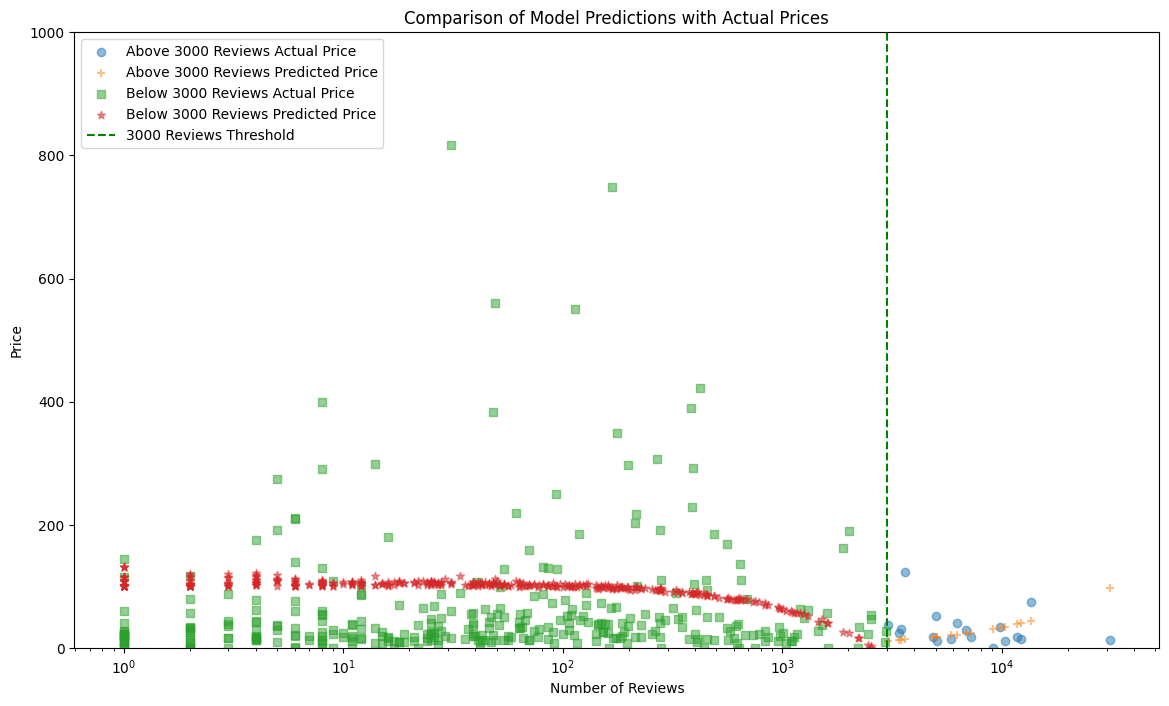

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample 0.1% of the data randomly without replacement from each dataset
sampled_original = predictions.sample(False, 0.001)
sampled_above_3000 = above_3000_predictions.sample(False, 0.001)
sampled_below_3000 = below_3000_predictions.sample(False, 0.001)

# Convert to Pandas DataFrame
original_pdf = sampled_original.select("reviews", "price", "prediction").toPandas()
above_3000_pdf = sampled_above_3000.select("reviews", "price", "prediction").toPandas()
below_3000_pdf = sampled_below_3000.select("reviews", "price", "prediction").toPandas()

# Plotting
plt.figure(figsize=(14, 8))

# Original model scatter plot
#plt.scatter(original_pdf['reviews'], original_pdf['price'], alpha=0.5, label='Original Model Actual Price')
#plt.scatter(original_pdf['reviews'], original_pdf['prediction'], alpha=0.5, label='Original Model Predicted Price', marker='x')

# Above 3000 reviews model scatter plot
plt.scatter(above_3000_pdf['reviews'], above_3000_pdf['price'], alpha=0.5, label='Above 3000 Reviews Actual Price', marker='o')
plt.scatter(above_3000_pdf['reviews'], above_3000_pdf['prediction'], alpha=0.5, label='Above 3000 Reviews Predicted Price', marker='+')

# Below 3000 reviews model scatter plot
plt.scatter(below_3000_pdf['reviews'], below_3000_pdf['price'], alpha=0.5, label='Below 3000 Reviews Actual Price', marker='s')
plt.scatter(below_3000_pdf['reviews'], below_3000_pdf['prediction'], alpha=0.5, label='Below 3000 Reviews Predicted Price', marker='*')

plt.axvline(x=3000, color='green', linestyle='--', label='3000 Reviews Threshold')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.title('Comparison of Model Predictions with Actual Prices')
plt.legend()
# Set y-axis limit to less than 2000
plt.ylim(0, 1000)
plt.xscale('log')  # Optional: Use logarithmic scale if the reviews vary by orders of magnitude
plt.show()

In [ ]:
!pip install plotly


In [ ]:
from pyspark.sql import SparkSession
import plotly.express as px
import pandas as pd
sampled_data = df.sample(False, 0.001)
sampled_data = sampled_data.toPandas()

In [ ]:
# Handle non-numeric values gracefully
sampled_data["stars"] = pd.to_numeric(sampled_data["stars"], errors='coerce')
sampled_data["reviews"] = pd.to_numeric(sampled_data["reviews"], errors='coerce')
sampled_data["price"] = pd.to_numeric(sampled_data["price"], errors='coerce')

# Replace NaN values in the 'price' column with a default value
default_price = 0  # You can change this to any default value you prefer
sampled_data["price"].fillna(default_price, inplace=True)

# Create an interactive scatter plot using Plotly Express
fig = px.scatter(sampled_data, x='stars', y='reviews', size='price', color='price',
                 hover_name='title', title='Interactive Dashboard for Product Data')

# Show the figure
fig.show()


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Replace NaN values in the 'price' column with a default value
default_price = 0
sampled_data["price"].fillna(default_price, inplace=True)

# Function to remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

# Remove outliers from 'stars', 'reviews', and 'price' columns
sampled_data = remove_outliers(sampled_data, 'stars')
sampled_data = remove_outliers(sampled_data, 'reviews')
sampled_data = remove_outliers(sampled_data, 'price')

# Create scatter plot
scatter_fig = px.scatter(sampled_data, x='stars', y='reviews', size='price', color='price',
                        hover_name='title', title='Interactive Dashboard: Scatter Plot (Without Outliers)')

# Create histogram
histogram_fig = px.histogram(sampled_data, x='price', title='Histogram of Prices (Without Outliers)')

# Create summary statistics table using Plotly Graph Objects
table_trace = go.Figure(data=[go.Table(
    header=dict(values=['Statistic', 'Value']),
    cells=dict(values=[
        ['Mean Stars', 'Mean Reviews', 'Mean Price'],
        [sampled_data['stars'].mean(), sampled_data['reviews'].mean(), sampled_data['price'].mean()]
    ])
)])

# Update layout for better presentation
table_trace.update_layout(showlegend=False)

# Show the scatter plot
scatter_fig.show()

# Show the histogram
histogram_fig.show()

# Show the table
table_trace.show()


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Sample 0.1% of the data randomly without replacement from each dataset
sampled_original = predictions.sample(False, 0.001)
sampled_above_3000 = above_3000_predictions.sample(False, 0.001)
sampled_below_3000 = below_3000_predictions.sample(False, 0.001)

In [ ]:
# Convert to Pandas DataFrame
original_pdf = sampled_original.select("reviews", "price", "prediction").toPandas()
above_3000_pdf = sampled_above_3000.select("reviews", "price", "prediction").toPandas()
below_3000_pdf = sampled_below_3000.select("reviews", "price", "prediction").toPandas()

# Create scatter plots using Plotly Express
scatter_original = px.scatter(original_pdf, x='reviews', y='price', color='prediction',
                              title='Original Model Predictions vs. Actual Prices')
scatter_above_3000 = px.scatter(above_3000_pdf, x='reviews', y='price', color='prediction',
                                title='Above 3000 Reviews Model Predictions vs. Actual Prices')
scatter_below_3000 = px.scatter(below_3000_pdf, x='reviews', y='price', color='prediction',
                                title='Below 3000 Reviews Model Predictions vs. Actual Prices')

# Create threshold line
threshold_line = go.Figure()
threshold_line.add_trace(go.Scatter(x=[3000, 3000], y=[0, 1000], mode='lines', name='3000 Reviews Threshold',
                                    line=dict(color='green', dash='dash')))

# Create subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=('Original Model', 'Above 3000 Reviews Model', 'Below 3000 Reviews Model'))

# Add scatter plots to the subplot layout
fig.add_trace(scatter_original['data'][0], row=1, col=1)
fig.add_trace(scatter_above_3000['data'][0], row=1, col=2)
fig.add_trace(scatter_below_3000['data'][0], row=2, col=1)

# Add threshold line separately to the layout
fig.add_trace(threshold_line['data'][0], row=2, col=1)

# Update layout for better presentation
fig.update_layout(showlegend=False, height=600, width=900, title_text='Comparison of Model Predictions with Actual Prices')

# Show the dashboard
fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from scipy.stats import pearsonr

# Function to remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

# Remove outliers from each dataset
original_pdf_cleaned = remove_outliers(original_pdf, 'reviews')
above_3000_pdf_cleaned = remove_outliers(above_3000_pdf, 'reviews')
below_3000_pdf_cleaned = remove_outliers(below_3000_pdf, 'reviews')

# Create scatter plots using Plotly Express after cleaning outliers
scatter_original_cleaned = px.scatter(original_pdf_cleaned, x='reviews', y='price', color='prediction',
                                      trendline='ols', labels={'prediction': 'Original Model Predicted Price'},
                                      title='Original Model Predictions vs. Actual Prices (Outliers Removed)')
scatter_above_3000_cleaned = px.scatter(above_3000_pdf_cleaned, x='reviews', y='price', color='prediction',
                                        trendline='ols', labels={'prediction': 'Above 3000 Reviews Model Predicted Price'},
                                        title='Above 3000 Reviews Model Predictions vs. Actual Prices (Outliers Removed)')
scatter_below_3000_cleaned = px.scatter(below_3000_pdf_cleaned, x='reviews', y='price', color='prediction',
                                        trendline='ols', labels={'prediction': 'Below 3000 Reviews Model Predictions'},
                                        title='Below 3000 Reviews Model Predictions vs. Actual Prices (Outliers Removed)')

# Calculate correlations for each dataset
correlation_original = pearsonr(original_pdf_cleaned['reviews'], original_pdf_cleaned['price'])[0]
correlation_above_3000 = pearsonr(above_3000_pdf_cleaned['reviews'], above_3000_pdf_cleaned['price'])[0]
correlation_below_3000 = pearsonr(below_3000_pdf_cleaned['reviews'], below_3000_pdf_cleaned['price'])[0]

# Create a separate figure for correlation information
correlation_fig = go.Figure(data=[go.Table(
    header=dict(values=['Dataset', 'Correlation']),
    cells=dict(values=[['Original Model', 'Above 3000 Reviews Model', 'Below 3000 Reviews Model'],
                       [correlation_original, correlation_above_3000, correlation_below_3000]])
)])

# Update layout for better presentation
correlation_fig.update_layout(title_text='Correlation Information')

# Show the cleaned stats dashboard
scatter_original_cleaned.show()
scatter_above_3000_cleaned.show()
scatter_below_3000_cleaned.show()
correlation_fig.show()
